# Exploring Fair Face with CLIP and GradCAM

## Imports

In [2]:
import clip
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image
import torch
import numpy as np
import random
import torch.nn.functional as F
from pathlib import Path
from scipy.ndimage import gaussian_filter
from torch import nn
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
%matplotlib inline

print('\nLoading model...')
available_models = ['RN50', 'RN101', 'RN50x4', 'RN50x16']
layers = ['layer4', 'layer3', 'layer2', 'layer1']

clip_model = available_models[0]
saliency_layer = layers[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)
print(f"Done! Model loaded to {device} device")


Loading model...
Done! Model loaded to cuda device


## Helper functions

In [4]:
def normalize(x: np.ndarray) -> np.ndarray:
    x = x - x.min()
    return x / 0.6

def getAttMap(img, attn_map, blur=True):
    img = img[:,:,:1]
    if blur:
        attn_map = gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('plasma')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, title, blur=True):
    _, axes = plt.subplots(1, 2)
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.title(title)
    plt.show()

def save_attn(img, attn_map, title, fname, blur=True):
    _, axes = plt.subplots(1, 2)
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.title(title)
    plt.savefig(fname, bbox_inches='tight')
    
def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

### Scores

In [5]:
def get_scores(img_input, voc_classes):
    image_input = img_input
    text_inputs = torch.cat(
        [clip.tokenize(f"a photo of a {c}") for c in voc_classes]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    values, indices = similarity[0].topk(len(similarity[0]))
    scores = list()
    for value, index in zip(values, indices):
        scores.append((voc_classes[index], round(100 * value.item(), 2)))
    return scores

### GradCAM

In [6]:
class Hook:

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


def gradCAM(
        model: nn.Module,
        input: torch.Tensor,
        target: torch.Tensor,
        layer: nn.Module
) -> torch.Tensor:
    if input.grad is not None:
        input.grad.data.zero_()

    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        alpha = grad.mean(dim=(2, 3), keepdim=True)
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        gradcam = torch.clamp(gradcam, min=0)

    gradcam = F.interpolate(gradcam,
                            input.shape[2:],
                            mode='bicubic',
                            align_corners=False)

    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam

## FairFace DataFrame

In [7]:
path = "/home/lazye/Documents/ufrgs/mcs/datasets/FairFace/"
fface_df = pd.read_csv(f"{path}/train/fairface_label_train.csv")
print(fface_df.head())

          file    age  gender        race  service_test
0  train/1.jpg  50-59    Male  East Asian          True
1  train/2.jpg  30-39  Female      Indian         False
2  train/3.jpg    3-9  Female       Black         False
3  train/4.jpg  20-29  Female      Indian          True
4  train/5.jpg  20-29  Female      Indian          True


In [35]:
fface_df['race'].value_counts()

race
White              16527
Latino_Hispanic    13367
Indian             12319
East Asian         12287
Black              12233
Southeast Asian    10795
Middle Eastern      9216
Name: count, dtype: int64

In [9]:
def filter_df(df, race=None, gender=None):
    new_df = df
    if gender:
        new_df = new_df[new_df['gender'] == gender]
    if race:
        new_df = new_df[new_df['race'] == race]
    return new_df


In [10]:
def make_grid(imgs, rows, cols):
    fig = plt.figure()
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(rows, cols),
                    axes_pad=0.1,
                    )


    for ax, im in zip(grid, imgs):
        ax.set_axis_off()
        ax.imshow(im)

    plt.savefig('imgrid.png', bbox_inches='tight')

In [11]:
def random_sample(df, race=None, gender=None):
    new_df = df
    
    if race:
        new_df = new_df[new_df['race'] == race]
    if gender:
        new_df = new_df[new_df['gender'] == gender]
    
    idx = random.randint(0, len(new_df))
    img = new_df.iloc[idx]
    img = plt.imread(path + img['file'])
    return img
    

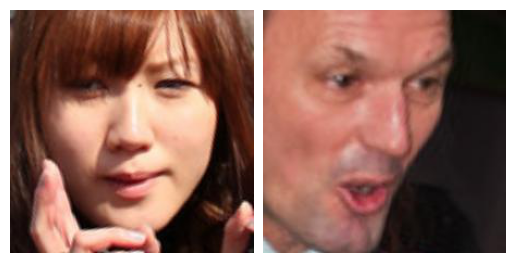

In [38]:
imgs = list()
imgs.append(random_sample(fface_df, 'White', 'Female'))
imgs.append(random_sample(fface_df, 'White', 'Male'))
# imgs.append(random_sample(fface_df, 'White', 'Female'))


make_grid(imgs, 1, len(imgs))

In [37]:
grid_path = "imgrid.png"
image_np = cv2.imread("imgrid.png")
circled_img = image_np.copy()
circled_img = cv2.circle(img=circled_img, center=(
    140, 134), radius=110, color=(0, 0, 255), thickness=3)

cv2.imwrite('red-circle.png', circled_img)

# cv2.imshow('img', circled_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True

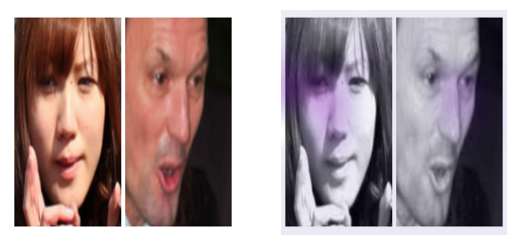

[('man', 54.49), ('woman', 45.51)]


In [40]:
grid_path = "imgrid.png"
label = 'man'

image_input = preprocess(Image.open(grid_path)).unsqueeze(0).to(device)
image_np = load_image(grid_path, model.visual.input_resolution)
text_input = clip.tokenize([f'a photo of a {label}']).to(device)
attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)

attn_map = attn_map.squeeze().detach().cpu().numpy()
viz_attn(image_np, attn_map, '', grid_path)

print(get_scores(image_input, ['man', 'woman']))

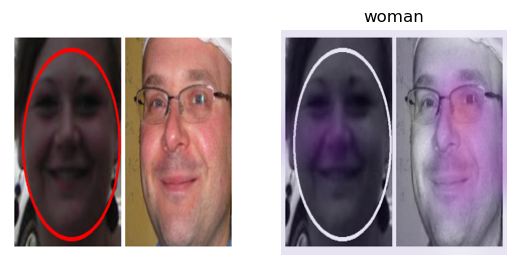

[('man', 67.92), ('woman', 32.08)]


In [41]:
grid_path = "red-circle.png"
label = 'woman'

image_input = preprocess(Image.open(grid_path)).unsqueeze(0).to(device)
image_np = load_image(grid_path, model.visual.input_resolution)
text_input = clip.tokenize([f'a photo of a {label}']).to(device)
attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)

attn_map = attn_map.squeeze().detach().cpu().numpy()
viz_attn(image_np, attn_map, label, grid_path)

print(get_scores(image_input, ['man', 'woman']))